# Marketplace Analysis Case Study

### Compiled by: Giang Nguyen

This is a case study on marketplace company that matches freelance labor with local demand, allowing consumers to find immediate help with everyday tasks, including cleaning, moving, delivery and handyman work.

## The Data

### visitor

This dataset contains a list of search results. Each result is a pro that matched a specific visitor’s search.

- row_number (integer): row number in data set

- visitor_id (integer): unique identifier for the visitor that the search result is associated with

- search_timestamp (timestamp): timestamp of when the visitor loaded the search results

- category (string): category of the visitor’s search

- pro_user_id (integer): unique identifier for the pro

- num_reviews (integer): number of reviews that the pro had at the time of the search

- avg_rating (float): average rating across pro’s reviews

- pro_last_active_time_before_search (timestamp): timestamp of when the pro last
responded to a customer that contacted them, prior to the search_timestamp


- cost_estimate_cents (integer): pro’s price estimate for the visitor’s project, in cents. For
House Cleaning searches, this is the price estimate for the entire project. For Local Moving
searches, this is the estimated hourly rate.

- result_position (integer): pro’s rank in search results. Rank = 1 means the pro was ranked
first among the search results.

- service_page_viewed (boolean): TRUE indicates that the visitor clicked to view the pro’s
profile, FALSE otherwise


### contacts

This dataset contains a list of customers reaching out to pros. Each row is a visitor that reached out to a
pro through a search in the Visitors CSV.

- visitor_id (integer): unique identifier for the visitor that reached out to the pro

- pro_user_id (integer): unique identifier for the pro that the visitor contacted

- contact_id (integer): unique identifier for the visitor-pro contact

- hired (boolean): TRUE indicates that the visitor eventually hired the pro, FALSE otherwise


## Case Study
I decided to take a closer look at performance in two of its largest categories in the company - House
Cleaning and Local Moving. I will then provide analysis on what types of pros our customers are interested in. I will also provide my recommendations for how we can improve and grow the company's marketplace.

For the privacy of the data, I will only make the dataset visible in this Jupyter Notebook without posting the actual data on github.


# Load Data

In [2]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(15, 7)})


In [3]:
#load in the dataset
contact = pd.read_csv('Contacts.csv')
visitor = pd.read_csv('Visitors.csv')

In [4]:
#view the info and dimesion of contact dataset
contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 4 columns):
visitor_id     1504 non-null int64
pro_user_id    1504 non-null int64
contact_id     1504 non-null int64
hired          1504 non-null bool
dtypes: bool(1), int64(3)
memory usage: 36.8 KB


In [5]:
#view the info and dimesion of visitor dataset
visitor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26102 entries, 0 to 26101
Data columns (total 11 columns):
row_number                            26102 non-null int64
visitor_id                            26102 non-null int64
search_timestamp                      26102 non-null object
category                              26102 non-null object
pro_user_id                           26102 non-null int64
num_reviews                           26102 non-null int64
avg_rating                            24947 non-null float64
pro_last_active_time_before_search    25035 non-null object
cost_estimate_cents                   23944 non-null float64
result_position                       26102 non-null int64
service_page_viewed                   26102 non-null bool
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 2.0+ MB


In [6]:
#edit the time format
visitor.search_timestamp = pd.to_datetime(visitor.search_timestamp).dt.strftime('%Y-%m-%d %H:%M:%S')
visitor.pro_last_active_time_before_search = pd.to_datetime(
    visitor.pro_last_active_time_before_search).dt.strftime('%Y-%m-%d %H:%M:%S')

# Exploratory Data Analysis

## Clicks

In [7]:
#Hours difference between the time search and time that pros last online
visitor['search_timestamp'] = pd.to_datetime(visitor['search_timestamp'])

visitor['pro_last_active_time_before_search'] = pd.to_datetime(visitor['pro_last_active_time_before_search'])

visitor['time_delta'] = (visitor.search_timestamp - visitor.pro_last_active_time_before_search).astype('timedelta64[m]')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

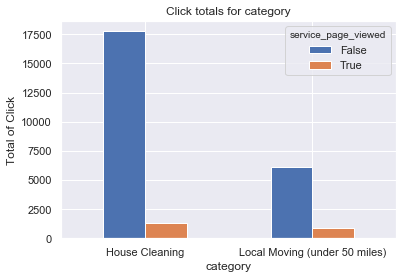

In [8]:
pd.crosstab(visitor.category,visitor.service_page_viewed).plot(kind='bar')
plt.title('Click totals for category')
plt.xlabel('category')
plt.ylabel('Total of Click') 
plt.xticks(rotation=0)

### What is the Click through rate?

In [9]:
#general
count_no_click = len(visitor[visitor['service_page_viewed']==False])
count_click = len(visitor[visitor['service_page_viewed']==True])

pct_of_click = count_click/(count_no_click+count_click)
print("percentage of click is", pct_of_click*100)
pct_of_no_click = count_no_click/(count_no_click+count_click)
print("percentage of no click", pct_of_no_click*100)

percentage of click is 8.424641789901157
percentage of no click 91.57535821009884


From this ratio, we understand that there is an imbalance between the click and no_click classes that we need to address later on when we apply XGboost and Logistic Regression

In [10]:
visitor.head()

,row_number,visitor_id,search_timestamp,category,pro_user_id,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,time_delta
0,15173,344101422347558000,2018-11-26 15:43:43,Local Moving (under 50 miles),343959583718981000,0,NaN,NaT,NaN,6,False,NaN
1,8426,344461605879021000,2018-11-30 19:46:46,House Cleaning,344053677817806000,0,NaN,2018-11-29 00:32:46,8900.0,6,False,2594.0
2,12809,344142189241475000,2018-11-27 03:03:09,House Cleaning,343931062348177000,0,NaN,NaT,10000.0,21,False,NaN
3,17310,344215295106097000,2018-11-27 23:21:35,House Cleaning,343931062348177000,0,NaN,NaT,10000.0,22,False,NaN
4,10072,344364289304010000,2018-11-29 16:44:50,House Cleaning,343934345272852000,0,NaN,NaT,9000.0,13,False,NaN


### Plotting timeline of clicks

In [11]:
#add month, date, day of the weeks to see the distribution of each segment

click_cnt = visitor.loc[visitor['service_page_viewed']==True].groupby(
    ['search_timestamp','category']).count().reset_index()

click_cnt = click_cnt[['search_timestamp','category','service_page_viewed']]

#month
click_cnt['month']=click_cnt['search_timestamp'].dt.month

#date
click_cnt['dates'] = click_cnt['search_timestamp'].dt.date

#day of a week
click_cnt['dates'] = click_cnt['search_timestamp'].dt.day_name()

#period of a day
b = [-1,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']

click_cnt = click_cnt.assign(session=pd.cut(click_cnt.search_timestamp.dt.hour, bins=b, labels=l))


click_cnt.head()



,search_timestamp,category,service_page_viewed,month,dates,session
0,2018-10-01 00:40:53,House Cleaning,1,10,Monday,Late Night
1,2018-10-01 00:43:15,House Cleaning,1,10,Monday,Late Night
2,2018-10-01 01:15:21,House Cleaning,1,10,Monday,Late Night
3,2018-10-01 02:24:26,House Cleaning,1,10,Monday,Late Night
4,2018-10-01 04:03:01,House Cleaning,1,10,Monday,Late Night


Text(0, 0.5, 'Total of Click')

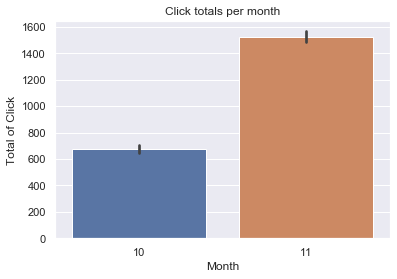

In [12]:
#counts of clicks by month
sns.barplot(x="month", y="service_page_viewed", data=click_cnt,estimator=sum)
plt.title('Click totals per month')
plt.xlabel('Month')
plt.ylabel('Total of Click') 

Text(0, 0.5, 'Total of Click')

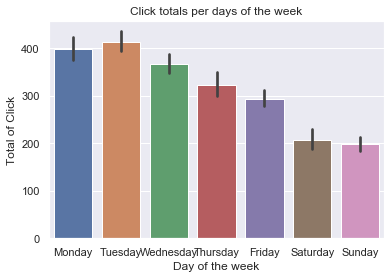

In [13]:
#counts of clicks by days of a week

sns.barplot(x="dates", y="service_page_viewed", data=click_cnt,estimator=sum)
plt.title('Click totals per days of the week')
plt.xlabel('Day of the week')
plt.ylabel('Total of Click') 

Text(0, 0.5, 'Total of Click')

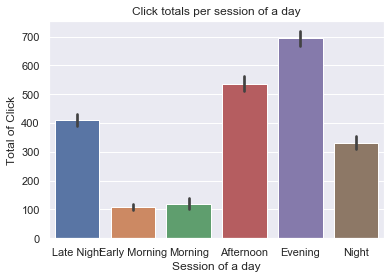

In [14]:
#counts of clicks by sessions of a day

sns.barplot(x="session", y="service_page_viewed", data=click_cnt,estimator=sum)
plt.title('Click totals per session of a day')
plt.xlabel('Session of a day')
plt.ylabel('Total of Click') 

### Breakdown by category

In [15]:

#house cleaning rolling mean of clicks

click_cnt_hc1 = click_cnt.loc[click_cnt['category']=='House Cleaning']\
    .groupby(['search_timestamp'])['service_page_viewed'].sum().reset_index()

#rolling mean of 7 days

click_cnt_hc1=click_cnt_hc1.set_index('search_timestamp').rolling(window=7).mean()

click_cnt_hc1=click_cnt_hc1.dropna()

click_cnt_hc1=click_cnt_hc1.reset_index()

click_cnt_hc1['search_timestamp'] = pd.to_datetime(click_cnt_hc1['search_timestamp'])

click_cnt_hc1 = pd.DataFrame(click_cnt_hc1)

click_cnt_hc1 = click_cnt_hc1.sort_values(by='search_timestamp')

click_cnt_hc1.describe()

,service_page_viewed
count,935.000000
mean,1.359206
std,0.300314
min,1.000000
25%,1.142857
50%,1.285714
75%,1.571429
max,2.857143


In [16]:

#house moving rolling mean of clicks

click_cnt_m1 = click_cnt.loc[click_cnt['category']=='Local Moving (under 50 miles)']\
    .groupby(['search_timestamp'])['service_page_viewed'].sum().reset_index()

#rolling mean of 7 days

click_cnt_m1=click_cnt_m1.set_index('search_timestamp').rolling(window=7).mean()

click_cnt_m1=click_cnt_m1.dropna()

click_cnt_m1=click_cnt_m1.reset_index()

click_cnt_m1['search_timestamp'] = pd.to_datetime(click_cnt_m1['search_timestamp'])

click_cnt_m1 = pd.DataFrame(click_cnt_m1)

click_cnt_m1 = click_cnt_m1.sort_values(by='search_timestamp')

click_cnt_m1.describe()

,service_page_viewed
count,771.000000
mean,1.184918
std,0.173989
min,1.000000
25%,1.000000
50%,1.142857
75%,1.285714
max,2.000000


In [17]:
#prepare the data for plotting
click_cnt_m1['search_timestamp'] = pd.to_datetime(click_cnt_m1['search_timestamp'])

click_cnt_m1 = click_cnt_m1.set_index('search_timestamp')

click_cnt_hc1['search_timestamp'] = pd.to_datetime(click_cnt_hc1['search_timestamp'])

click_cnt_hc1 = click_cnt_hc1.set_index('search_timestamp')

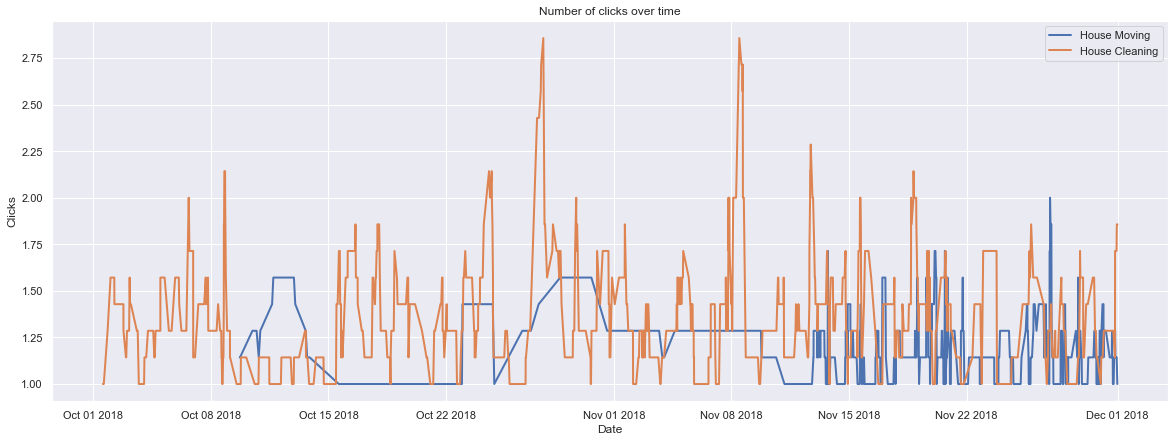

In [18]:
#make a line plot to see the trend of click over time
sns.set(rc={'figure.figsize':(20, 7)})

fig, ax = plt.subplots()

ax.plot(click_cnt_m1['service_page_viewed'],linewidth=2, label='House Moving')

ax.plot(click_cnt_hc1['service_page_viewed'],linewidth=2,  label='House Cleaning')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Clicks')
ax.set_title('Number of clicks over time');

The demand of House Cleaning sky-rocketed in late October and early November maybe due to Halloween Party and Thanksgiving season. While visitor often looking for more house moving in late November, probably due to family moving, relocate for job opportunities, or new office moving.

### What is the click through rate for each category?

In [19]:
#house cleaning
house_cleaning = visitor.loc[visitor['category']=='House Cleaning']

#house moving
house_moving = visitor.loc[visitor['category']=='Local Moving (under 50 miles)']

In [20]:
#house cleaning
count_no_click_c = len(house_cleaning[house_cleaning['service_page_viewed']==False])
count_click_c = len(house_cleaning[house_cleaning['service_page_viewed']==True])

pct_of_click_c = count_click_c/(count_no_click_c+count_click_c)
print("percentage of click is", pct_of_click_c*100)
pct_of_no_sub_c = count_no_click_c/(count_no_click_c+count_click_c)
print("percentage of no click", pct_of_no_sub_c*100)

percentage of click is 6.712501312060459
percentage of no click 93.28749868793955


From this ratio, we understand that there is an imbalance between the click and no_click classes that we need to address later on when we apply XGboost and Logistic Regression

In [21]:
#House moving
count_no_click_m = len(house_moving[house_moving['service_page_viewed']==False])
count_click_m = len(house_moving[house_moving['service_page_viewed']==True])

pct_of_click_m = count_click_m/(count_no_click_m+count_click_m)
print("percentage of click is", pct_of_click_m*100)
pct_of_no_sub_m = count_no_click_m/(count_no_click_m+count_click_m)
print("percentage of no click", pct_of_no_sub_m*100)

percentage of click is 13.053348467650396
percentage of no click 86.9466515323496


From this ratio, we understand that there is an imbalance between the click and no_click classes that we need to address later on when we apply XGboost and Logistic Regression

## Contacts

### What is the hiring conversion rate over contact?

In [22]:
contact.head()

,visitor_id,pro_user_id,contact_id,hired
0,339909111505494000,269676229116822000,339909524915273000,False
1,344128984608088000,343705945283207000,344129090535645000,False
2,344283283738624000,198869800397579000,344283629941841000,False
3,342932176648061000,198869800397579000,342932549106393000,False
4,344288410954719000,198869800397579000,344288499619061000,False


In [23]:
count_no_hire = len(contact[contact['hired']==False])
count_hire = len(contact[contact['hired']==True])

pct_of_hire = count_hire/(count_hire+count_no_hire)
print("percentage of hire is", pct_of_hire*100)
pct_of_no_hire = count_no_hire/(count_hire+count_no_hire)
print("percentage of no hire", pct_of_no_hire*100)

percentage of hire is 24.13563829787234
percentage of no hire 75.86436170212765


## Join Visitor and Contact Dataframe

In [24]:
join_df = pd.merge(visitor, contact,  how='left', left_on=['visitor_id','pro_user_id']\
                    , right_on = ['visitor_id','pro_user_id'])
join_df.head()

,row_number,visitor_id,search_timestamp,category,pro_user_id,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,time_delta,contact_id,hired
0,15173,344101422347558000,2018-11-26 15:43:43,Local Moving (under 50 miles),343959583718981000,0,NaN,NaT,NaN,6,False,NaN,NaN,NaN
1,8426,344461605879021000,2018-11-30 19:46:46,House Cleaning,344053677817806000,0,NaN,2018-11-29 00:32:46,8900.0,6,False,2594.0,NaN,NaN
2,12809,344142189241475000,2018-11-27 03:03:09,House Cleaning,343931062348177000,0,NaN,NaT,10000.0,21,False,NaN,NaN,NaN
3,17310,344215295106097000,2018-11-27 23:21:35,House Cleaning,343931062348177000,0,NaN,NaT,10000.0,22,False,NaN,NaN,NaN
4,10072,344364289304010000,2018-11-29 16:44:50,House Cleaning,343934345272852000,0,NaN,NaT,9000.0,13,False,NaN,NaN,NaN


(array([0, 1]), <a list of 2 Text xticklabel objects>)

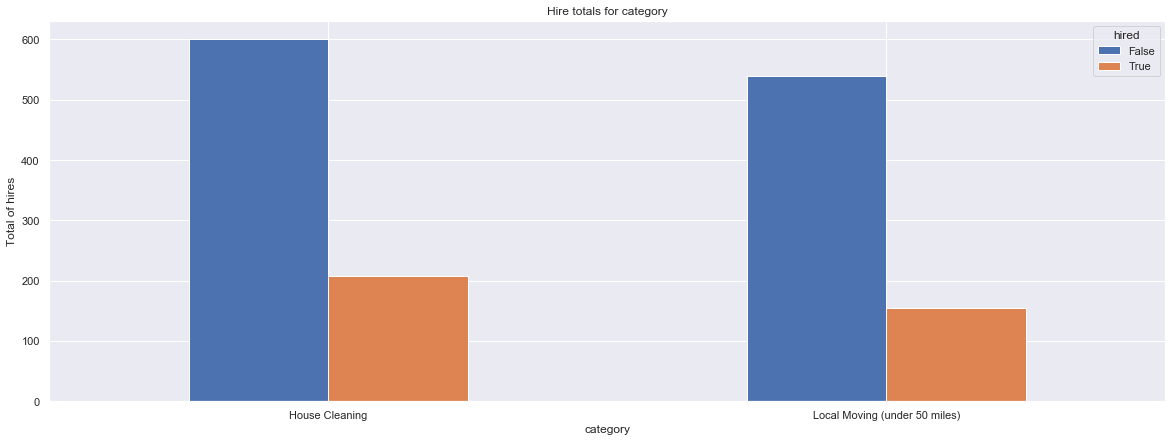

In [25]:
pd.crosstab(join_df.category,join_df.hired).plot(kind='bar')
plt.title('Hire totals for category')
plt.xlabel('category')
plt.ylabel('Total of hires') 
plt.xticks(rotation=0)

### Plotting the timeline

In [26]:
#add month, date, day of the weeks to see the distribution of each segment

hire_cnt = join_df.loc[join_df['hired']==True].groupby(
    ['search_timestamp','category']).count().reset_index()

hire_cnt = hire_cnt[['search_timestamp','category','hired']]


#month
hire_cnt['month']=hire_cnt['search_timestamp'].dt.month

#date
hire_cnt['dates'] = hire_cnt['search_timestamp'].dt.date

#day of a week
hire_cnt['dates'] = hire_cnt['search_timestamp'].dt.day_name()


#period of a day
b = [-1,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']

hire_cnt = hire_cnt.assign(session=pd.cut(hire_cnt.search_timestamp.dt.hour, bins=b, labels=l))

hire_cnt.head()

,search_timestamp,category,hired,month,dates,session
0,2018-10-01 00:43:15,House Cleaning,1,10,Monday,Late Night
1,2018-10-01 01:15:21,House Cleaning,1,10,Monday,Late Night
2,2018-10-01 14:50:40,House Cleaning,1,10,Monday,Afternoon
3,2018-10-02 05:51:48,House Cleaning,1,10,Tuesday,Early Morning
4,2018-10-02 18:54:55,House Cleaning,1,10,Tuesday,Evening


Text(0, 0.5, 'Total of hires')

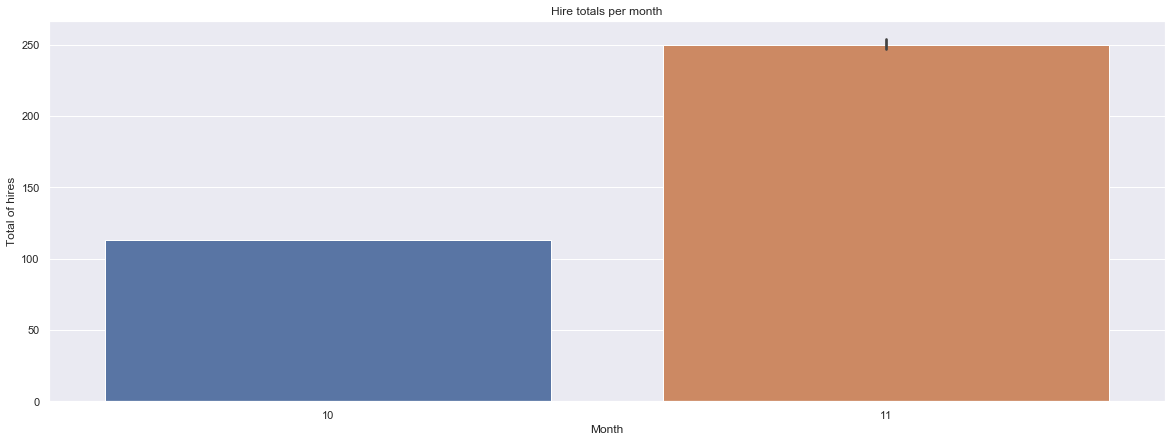

In [27]:
#counts of hires by month
sns.barplot(x="month", y="hired", data=hire_cnt,estimator=sum)
plt.title('Hire totals per month')
plt.xlabel('Month')
plt.ylabel('Total of hires') 

Text(0, 0.5, 'Total of hire')

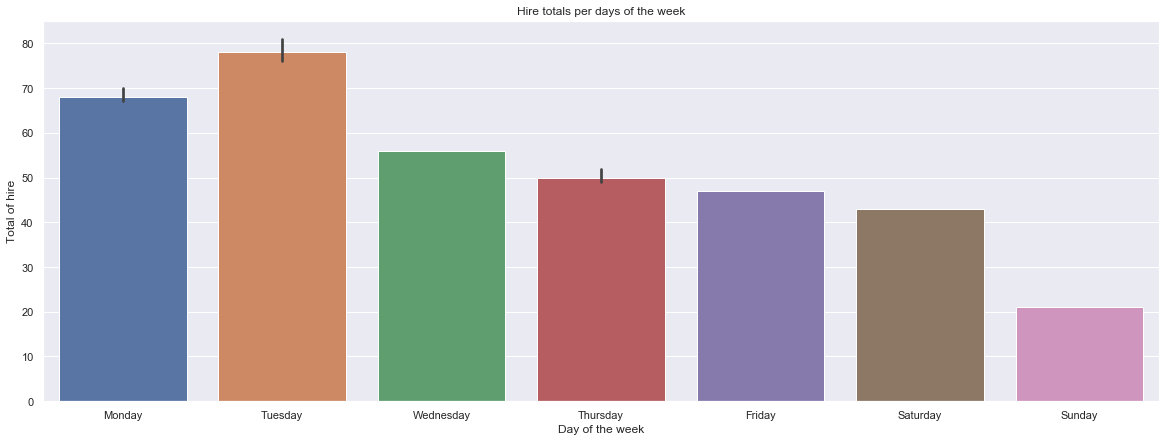

In [28]:
#counts of hires by days of a week

sns.barplot(x="dates", y="hired", data=hire_cnt,estimator=sum)
plt.title('Hire totals per days of the week')
plt.xlabel('Day of the week')
plt.ylabel('Total of hire') 

Text(0, 0.5, 'Total of hire')

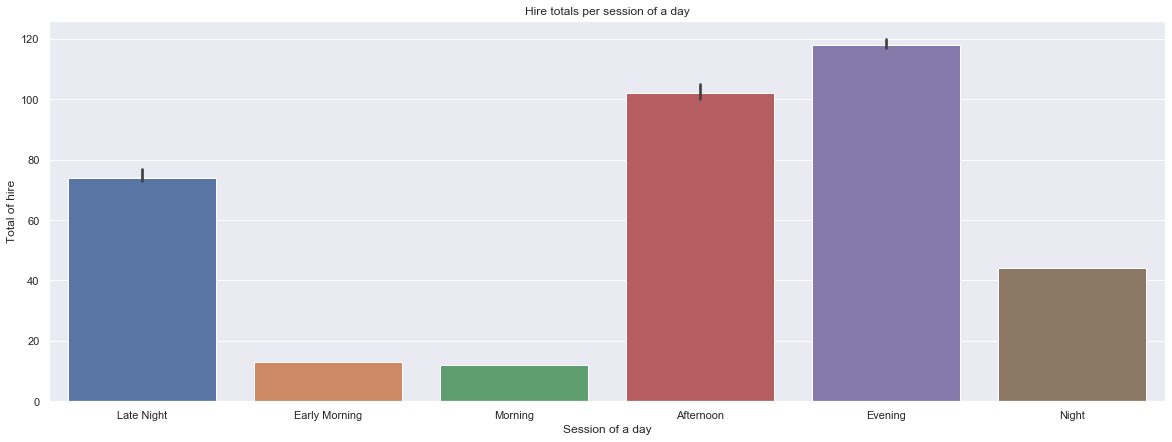

In [29]:
#counts of hires by sessions of a day

sns.barplot(x="session", y="hired", data=hire_cnt,estimator=sum)
plt.title('Hire totals per session of a day')
plt.xlabel('Session of a day')
plt.ylabel('Total of hire') 

### Breakdown by category

In [30]:

#house cleaning rolling mean of hires

click_cnt_hc2 = hire_cnt.loc[hire_cnt['category']=='House Cleaning']\
    .groupby(['search_timestamp'])['hired'].sum().reset_index()

#rolling mean of 7 days

click_cnt_hc2=click_cnt_hc2.set_index('search_timestamp').rolling(window=7).mean()

click_cnt_hc2=click_cnt_hc2.dropna()

click_cnt_hc2=click_cnt_hc2.reset_index()

click_cnt_hc2['search_timestamp'] = pd.to_datetime(click_cnt_hc2['search_timestamp'])

click_cnt_hc2 = pd.DataFrame(click_cnt_hc2)

click_cnt_hc2 = click_cnt_hc2.sort_values(by='search_timestamp')

click_cnt_hc2.describe()

,hired
count,201.000000
mean,1.004975
std,0.026257
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.142857


In [31]:
#house moving rolling mean of hires

click_cnt_m2 = hire_cnt.loc[hire_cnt['category']=='Local Moving (under 50 miles)']\
    .groupby(['search_timestamp'])['hired'].sum().reset_index()

#rolling mean of 7 days

click_cnt_m2=click_cnt_m2.set_index('search_timestamp').rolling(window=7).mean()

click_cnt_m2=click_cnt_m2.dropna()

click_cnt_m2=click_cnt_m2.reset_index()

click_cnt_m2['search_timestamp'] = pd.to_datetime(click_cnt_m2['search_timestamp'])

click_cnt_m2 = pd.DataFrame(click_cnt_m2)

click_cnt_m2 = click_cnt_m2.sort_values(by='search_timestamp')

click_cnt_m2.describe()

,hired
count,146.000000
mean,1.020548
std,0.050304
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.142857


In [32]:
#prepare the data for plotting
click_cnt_m2['search_timestamp'] = pd.to_datetime(click_cnt_m2['search_timestamp'])

click_cnt_m2 = click_cnt_m2.set_index('search_timestamp')

click_cnt_hc2['search_timestamp'] = pd.to_datetime(click_cnt_hc2['search_timestamp'])

click_cnt_hc2 = click_cnt_hc2.set_index('search_timestamp')

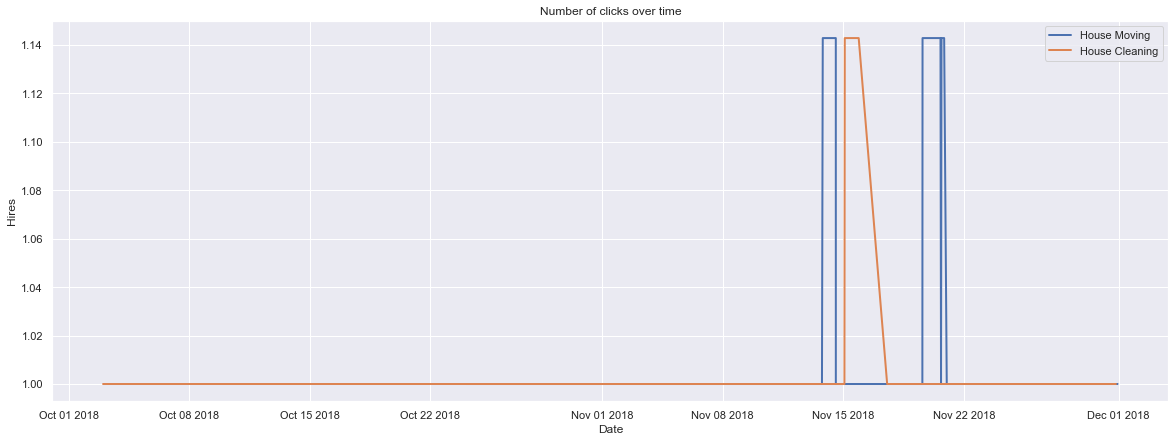

In [33]:
#make a line plot to see the trend of click over time
sns.set(rc={'figure.figsize':(20, 7)})

fig, ax = plt.subplots()

ax.plot(click_cnt_m2['hired'],linewidth=2, label='House Moving')

ax.plot(click_cnt_hc2['hired'],linewidth=2,  label='House Cleaning')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Hires')
ax.set_title('Number of clicks over time');

Even though we can see a clearer pattern of demand through number of clicks than hires, but we can see that we have high demand in House Moving in mid and late November while House Cleaning peaks in mid November only.

### What is the contacting conversion rate over clicks?

In [34]:
print("percentage of contacting is",(len(join_df['hired'].dropna())/count_click)*100)

percentage of contacting is 68.39472487494317


### What is the hiring conversion rate over clicks?

In [35]:
count_no_hire_cl = len(join_df[join_df['hired']==False])
count_hire_cl = len(join_df[join_df['hired']==True])

pct_of_hire_cl = count_hire_cl/(count_click)
print("percentage of hire is", pct_of_hire_cl*100)
pct_of_no_hire_cl = count_no_hire_cl/(count_click)
print("percentage of no hire", pct_of_no_hire_cl*100)

percentage of hire is 16.5075034106412
percentage of no hire 51.88722146430196


### Now we break it down into category

In [36]:
#house cleaning join
house_cleaning_join = join_df.loc[join_df['category']=='House Cleaning']

#house moving join
house_moving_join = join_df.loc[join_df['category']=='Local Moving (under 50 miles)']

### Hire conversion over contact

In [37]:
#House cleaning
count_no_hire_hc = len(house_cleaning_join[house_cleaning_join['hired']==False])
count_hire_hc = len(house_cleaning_join[house_cleaning_join['hired']==True])

pct_of_hire_hc = count_hire_hc/(count_hire_hc+count_no_hire_hc)
print("percentage of hire is", pct_of_hire_hc*100)
pct_count_no_hire_hc = count_no_hire_hc/(count_hire_hc+count_no_hire_hc)
print("percentage of no hire", pct_count_no_hire_hc*100)

percentage of hire is 25.710754017305316
percentage of no hire 74.28924598269468


In [38]:
#House Moving
count_no_hire_m = len(house_moving_join[house_moving_join['hired']==False])
count_hire_m = len(house_moving_join[house_moving_join['hired']==True])

pct_of_hire_m = count_hire_m/(count_hire_m+count_no_hire_m)
print("percentage of hire is", pct_of_hire_m*100)
pct_count_no_hire_m = count_no_hire_m/(count_hire_m+count_no_hire_m)
print("percentage of no hire", pct_count_no_hire_m*100)

percentage of hire is 22.302158273381295
percentage of no hire 77.6978417266187


### Hire conversion over click

In [39]:
#House Cleaning
count_no_hire_hc_cl = len(house_cleaning_join[house_cleaning_join['hired']==False])
count_hire_hc_cl = len(house_cleaning_join[house_cleaning_join['hired']==True])

pct_of_hire_hc_cl = count_hire_hc_cl/(count_click)
print("percentage of hire is", pct_of_hire_hc_cl*100)
pct_count_no_hire_hc_cl = count_no_hire_hc_cl/(count_click)
print("percentage of no hire", pct_count_no_hire_hc_cl*100)

percentage of hire is 9.458844929513416
percentage of no hire 27.330604820372894


In [40]:
#House Moving
count_no_hire_m_cl = len(house_moving_join[house_moving_join['hired']==False])
count_hire_m_cl = len(house_moving_join[house_moving_join['hired']==True])

pct_of_hire_m_cl = count_hire_m_cl/(count_click)
print("percentage of hire is", pct_of_hire_m_cl*100)
pct_count_no_hire_m_cl = count_no_hire_m_cl/(count_click)
print("percentage of no hire", pct_count_no_hire_m_cl*100)

percentage of hire is 7.048658481127785
percentage of no hire 24.556616643929058


### Contact conversion over click

In [41]:
print("percentage of contacting house cleaning is",(len(house_cleaning_join['hired'].dropna())/count_click)*100)
print("percentage of contacting house moving is",(len(house_moving_join['hired'].dropna())/count_click)*100)

percentage of contacting house cleaning is 36.78944974988631
percentage of contacting house moving is 31.605275125056842


### Sankey Diagram of user path

<img src="sankey.png">

Made by Google JSFiddle

### How many contacts before hiring?

In [42]:
contact1 = contact.drop(['pro_user_id'], axis=1)
contact2 = contact1.groupby(['visitor_id'])['hired'].value_counts().unstack().fillna(0).sort_values(by='visitor_id')
contact2.head()

hired,False,True
visitor_id,,
339208852905672000,1.0,0.0
339208995230892000,0.0,1.0
339210920208318000,0.0,1.0
339215065721331000,1.0,0.0
339220980268032000,1.0,0.0


In [43]:
contact2['cnt_hire'] = contact2[True] + contact2[False]

In [44]:
contact3 = contact2[contact2[True]>=1]

In [45]:
contact3.cnt_hire.mean()

1.0222841225626742

On average, there are 1.02 contacts before the visitor hire a pro

Text(0, 0.5, 'Frequency')

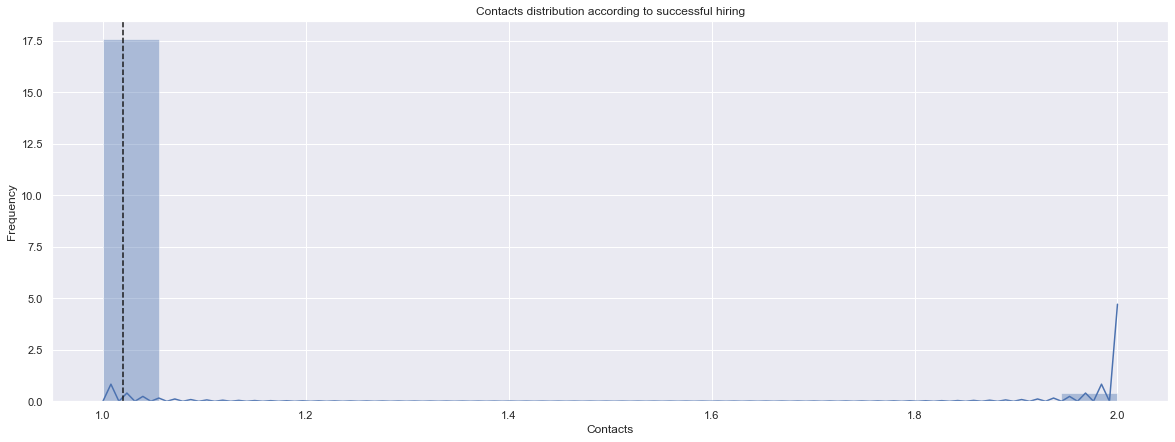

In [46]:
sns.distplot(contact3.reset_index().cnt_hire)
plt.axvline(1.02, color="k", linestyle="--")
plt.title('Contacts distribution according to successful hiring')
plt.xlabel('Contacts')
plt.ylabel('Frequency') 

### How many searchs before they click?

In [47]:
contact4 = join_df[['visitor_id','service_page_viewed']]
contact4 = contact4.groupby(['visitor_id'])['service_page_viewed'].value_counts().unstack().fillna(0).sort_values(by='visitor_id')
contact4.head()

service_page_viewed,False,True
visitor_id,,
339208852905672000,2.0,1.0
339208995230892000,1.0,1.0
339210920208318000,3.0,1.0
339211082814890000,4.0,0.0
339212932864344000,2.0,0.0


In [48]:
contact4['cnt_clicks'] = contact4[True] + contact4[False]

In [49]:
contact5 = contact4[contact4[True]>=1]

In [50]:
contact5.cnt_clicks.mean()

8.471478463329452

On average, there are 8.5 searches before a visitor clicks

Text(0, 0.5, 'Frequency')

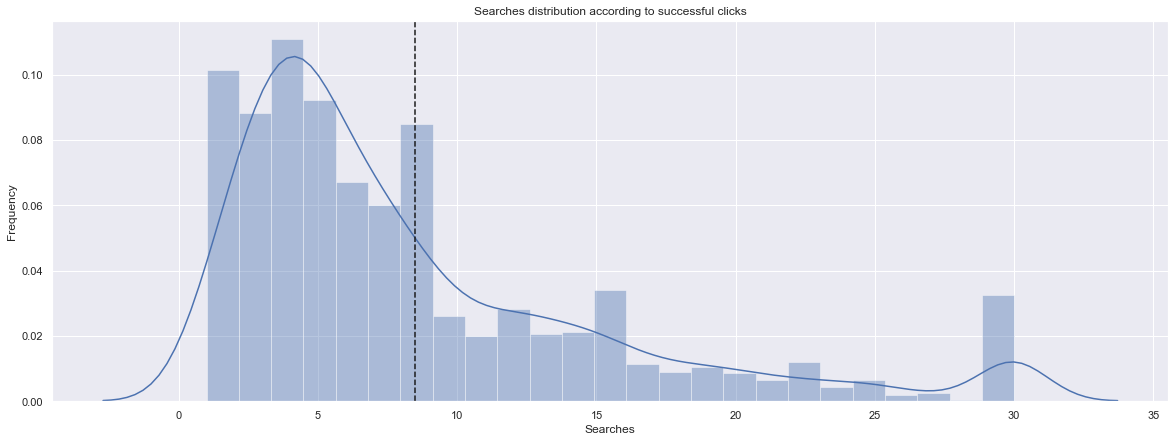

In [51]:
sns.distplot(contact5.reset_index().cnt_clicks)

plt.axvline(8.5, color="k", linestyle="--")

plt.title('Searches distribution according to successful clicks')
plt.xlabel('Searches')
plt.ylabel('Frequency') 

### How many clicks before contact?

In [52]:
contact6 = pd.merge(contact4, contact2,  how='left', left_on=['visitor_id']\
                    , right_on = ['visitor_id'])
contact6.head()

,False_x,True_x,cnt_clicks,False_y,True_y,cnt_hire
visitor_id,,,,,,
339208852905672000,2.0,1.0,3.0,1.0,0.0,1.0
339208995230892000,1.0,1.0,2.0,0.0,1.0,1.0
339210920208318000,3.0,1.0,4.0,0.0,1.0,1.0
339211082814890000,4.0,0.0,4.0,NaN,NaN,NaN
339212932864344000,2.0,0.0,2.0,NaN,NaN,NaN


In [53]:
contact7 = contact6[contact6['cnt_hire']>0]
contact7 = contact7[contact7['True_x']>=1]

In [54]:
contact7.cnt_clicks.mean()

8.573569482288828

On average, there are 8.6 clicks before a visitor contact

Text(0, 0.5, 'Frequency')

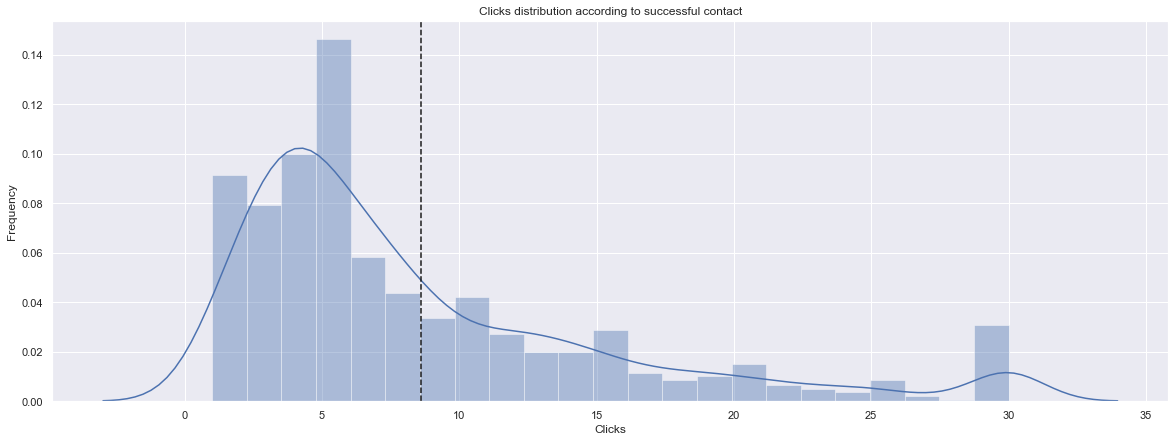

In [55]:
sns.distplot(contact7.reset_index().cnt_clicks)
plt.axvline(8.6, color="k", linestyle="--")

plt.title('Clicks distribution according to successful contact')
plt.xlabel('Clicks')
plt.ylabel('Frequency') 

### How many clicks before hire?

In [56]:
contact8 = pd.merge(contact5, contact3,  how='left', left_on=['visitor_id']\
                    , right_on = ['visitor_id'])
contact9 = contact8[contact8['True_y']>=1]

In [57]:
contact9.cnt_clicks.mean()

9.07563025210084

Text(0, 0.5, 'Frequency')

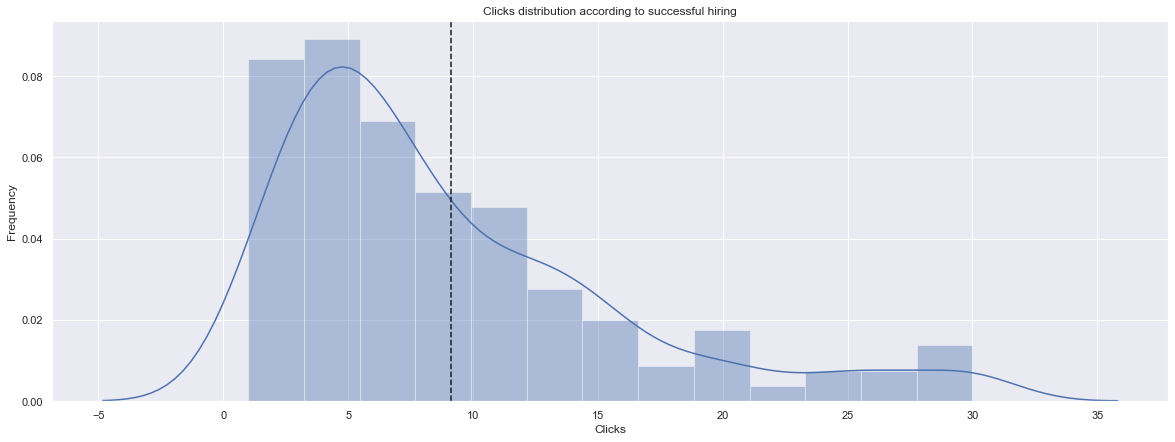

In [58]:
sns.distplot(contact9.reset_index().cnt_clicks)
plt.axvline(9.1, color="k", linestyle="--")

plt.title('Clicks distribution according to successful hiring')
plt.xlabel('Clicks')
plt.ylabel('Frequency') 

# Pros that visitors most interested in

After looking at the big picture of the health of our business and product, let's disect into which characters of the pros that attract visitor to convert the most

In [59]:
#Segment by clicks

round(join_df.groupby(['category','service_page_viewed'])[['num_reviews','avg_rating',
                                                     'cost_estimate_cents','result_position','time_delta']].mean(),2)

num_reviews  avg_rating  \
category                      service_page_viewed                            
House Cleaning                False                      27.65        4.68   
                              True                       55.07        4.75   
Local Moving (under 50 miles) False                     101.41        4.62   
                              True                      181.67        4.67   

                                                   cost_estimate_cents  \
category                      service_page_viewed                        
House Cleaning                False                           11848.54   
                              True                            10512.76   
Local Moving (under 50 miles) False                           10434.22   
                              True                             8936.96   

                                                   result_position  time_delta  
category                      service_page_viewed                               
House Cleaning                False                           8.95    28001.55  
                              True                            2.91     9875.59  
Local Moving (under 50 miles) False                           4.10     6227.62  
                              True                            1.87     3143.84

In [60]:
#Segment by hires

round(join_df.groupby(['category','hired'])[['num_reviews','avg_rating',
                                                     'cost_estimate_cents','result_position','time_delta']].mean(),2)

num_reviews  avg_rating  \
category                      hired                            
House Cleaning                False        53.87        4.77   
                              True         62.96        4.78   
Local Moving (under 50 miles) False       179.43        4.68   
                              True        187.95        4.66   

                                     cost_estimate_cents  result_position  \
category                      hired                                         
House Cleaning                False             10320.42             2.72   
                              True              10617.59             2.38   
Local Moving (under 50 miles) False              8973.03             1.72   
                              True               8647.95             1.99   

                                     time_delta  
category                      hired              
House Cleaning                False     9917.36  
                              True     11653.47  
Local Moving (under 50 miles) False     3372.10  
                              True      1319.45

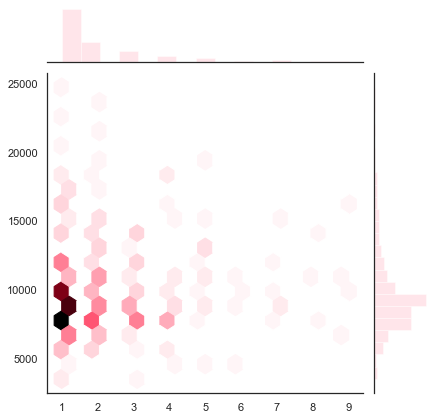

In [61]:
with sns.axes_style("white"):
    sns.jointplot(x=join_df.loc[join_df['hired']==True][['result_position']], \
                  y=join_df.loc[join_df['hired']==True][['cost_estimate_cents']], kind="hex", color="pink")


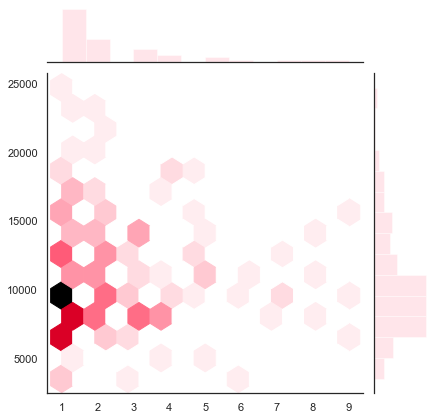

In [62]:
#take a closer look at house cleaning
with sns.axes_style("white"):
    sns.jointplot(x=house_cleaning_join.loc[house_cleaning_join['hired']==True][['result_position']], \
                  y=house_cleaning_join.loc[house_cleaning_join['hired']==True][['cost_estimate_cents']], kind="hex", color="pink")

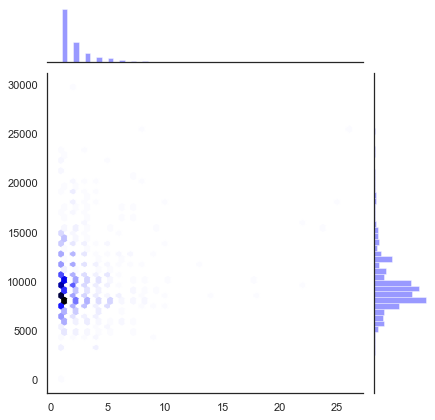

In [63]:
with sns.axes_style("white"):
    sns.jointplot(x=join_df.loc[join_df['hired']==False][['result_position']], \
                  y=join_df.loc[join_df['hired']==False][['cost_estimate_cents']], kind="hex", color="blue")

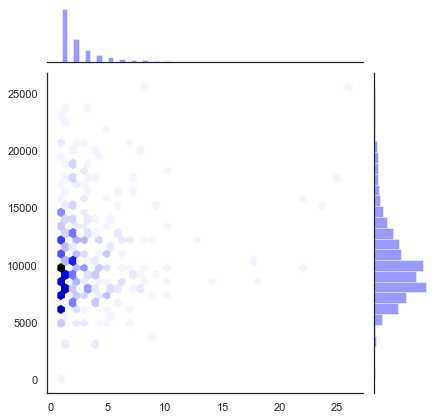

In [64]:
#take a closer look at house cleaning
with sns.axes_style("white"):
    sns.jointplot(x=house_cleaning_join.loc[house_cleaning_join['hired']==False][['result_position']], \
                  y=house_cleaning_join.loc[house_cleaning_join['hired']==False][['cost_estimate_cents']], kind="hex", color="blue")

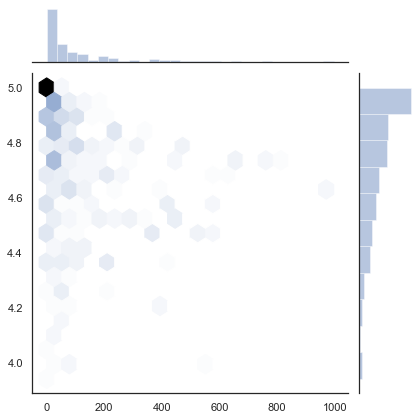

In [65]:
with sns.axes_style("white"):
    sns.jointplot(x=join_df.loc[join_df['hired']==True][['num_reviews']], \
                  y=join_df.loc[join_df['hired']==True][['avg_rating']], kind="hex");

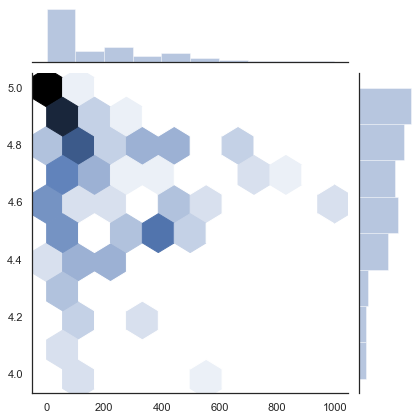

In [131]:
#Take a closer look at local-moving
with sns.axes_style("white"):
    sns.jointplot(x=house_moving_join.loc[house_moving_join['hired']==True][['num_reviews']], \
                  y=house_moving_join.loc[house_moving_join['hired']==True][['avg_rating']], kind="hex");

In [138]:
#construct the OLS model

X_m = house_moving_join['num_reviews']
y_m = house_moving_join['avg_rating']

# Note the difference in argument order
model_m = sm.OLS(y_m, X_m).fit()
predictions_m = model_m.predict(X_m) # make the predictions by the model

# Print out the statistics
#model_m.summary()

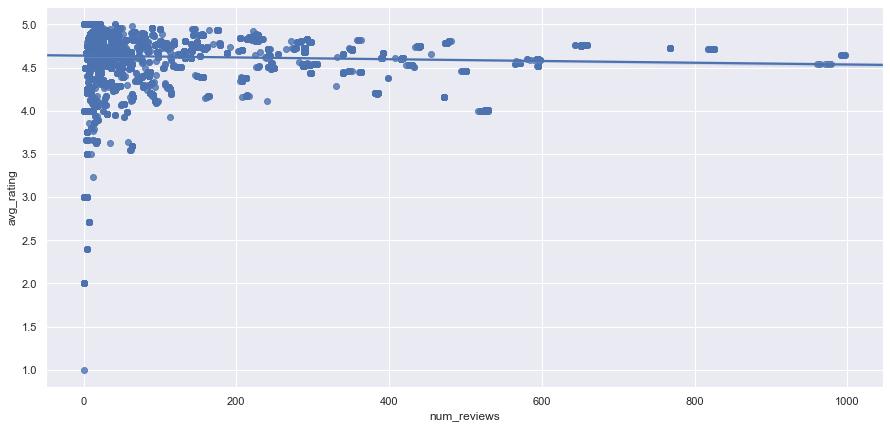

In [139]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.regplot(x=X_m, y=y_m)

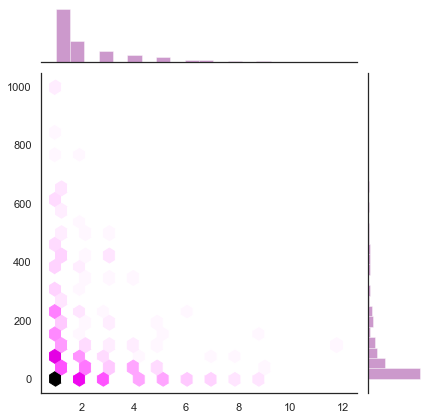

In [66]:
with sns.axes_style("white"):
    sns.jointplot(x=join_df.loc[join_df['hired']==True][['result_position']], \
                  y=join_df.loc[join_df['hired']==True][['num_reviews']], kind="hex", color="purple");

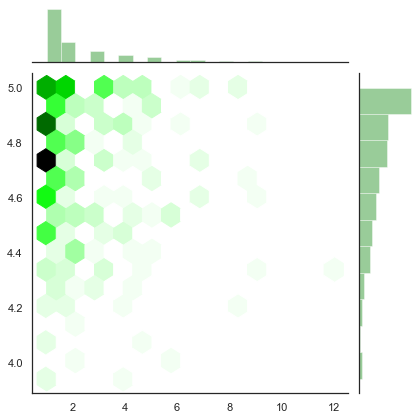

In [133]:
with sns.axes_style("white"):
    sns.jointplot(x=join_df.loc[join_df['hired']==True][['result_position']], \
                  y=join_df.loc[join_df['hired']==True][['avg_rating']], kind="hex", color="green");

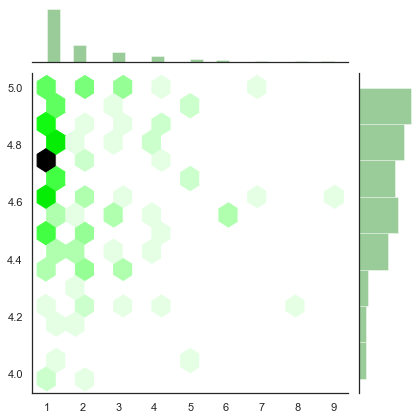

In [132]:
#taking a closer look at local-moving
with sns.axes_style("white"):
    sns.jointplot(x=house_moving_join.loc[house_moving_join['hired']==True][['result_position']], \
                  y=house_moving_join.loc[house_moving_join['hired']==True][['avg_rating']], kind="hex", color="green");

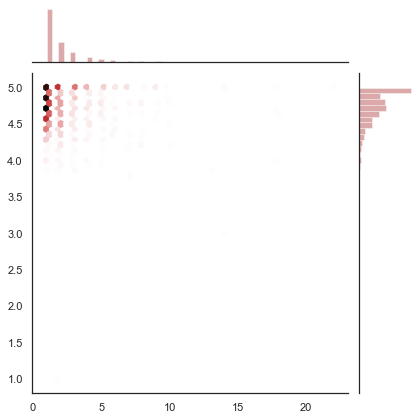

In [68]:
with sns.axes_style("white"):
    sns.jointplot(x=join_df.loc[join_df['hired']==False][['result_position']], \
                  y=join_df.loc[join_df['hired']==False][['avg_rating']], kind="hex", color="brown");

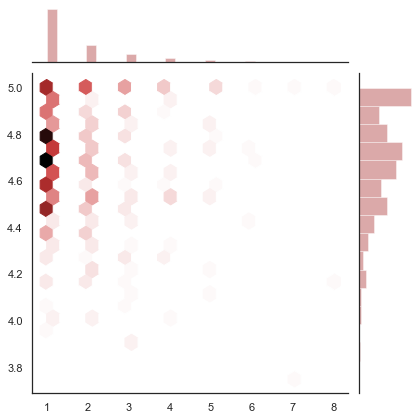

In [135]:
#taking a closer look at local-moving
with sns.axes_style("white"):
    sns.jointplot(x=house_moving_join.loc[house_moving_join['hired']==False][['result_position']], \
                  y=house_moving_join.loc[house_moving_join['hired']==False][['avg_rating']], kind="hex", color="brown");

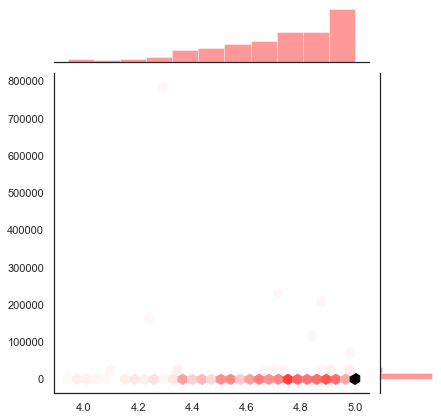

In [69]:
with sns.axes_style("white"):
    sns.jointplot(x=join_df.loc[join_df['hired']==True][['avg_rating']], \
                  y=join_df.loc[join_df['hired']==True][['time_delta']], kind="hex", color="red");

In [127]:
#Take a closer look at house cleaning
house_cleaning_join1 = house_cleaning_join.loc[house_cleaning_join['time_delta']>=10617] #mean of time delta for hired pros
house_cleaning_join2 = house_cleaning_join.loc[house_cleaning_join['time_delta']<10617] #mean of time delta for non-hire pros



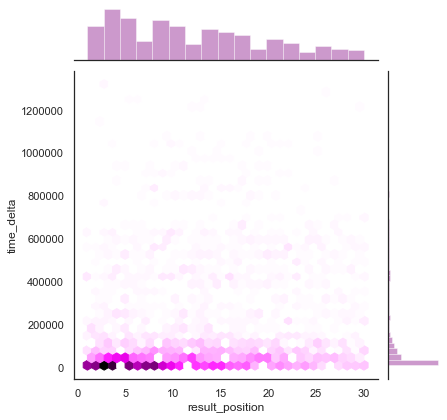

In [128]:
with sns.axes_style("white"):
    sns.jointplot(x=house_cleaning_join1['result_position'], \
                  y=house_cleaning_join1['time_delta'], kind="hex", color="purple");

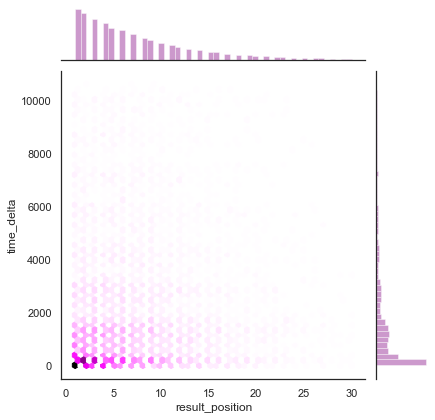

In [130]:
#Take a closer look at house cleaning
with sns.axes_style("white"):
    sns.jointplot(x=house_cleaning_join2['result_position'], \
                  y=house_cleaning_join2['time_delta'], kind="hex", color="purple");

# Perform XGboost for feature importance

In [72]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [74]:
#Train test split

join_df1 = join_df[['num_reviews','avg_rating','cost_estimate_cents',
                                  'result_position','time_delta','service_page_viewed']]
join_df1 = join_df1.fillna(0)
X = join_df1.loc[:, join_df1.columns != 'service_page_viewed']
y = join_df1.loc[:, join_df1.columns == 'service_page_viewed']

In [75]:
#Address imbalance problem using SMOTE
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no click data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of click data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  33438
Number of no subscription in oversampled data 16719
Number of subscription 16719
Proportion of no click data in oversampled data is  0.5
Proportion of click data in oversampled data is  0.5


/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [76]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


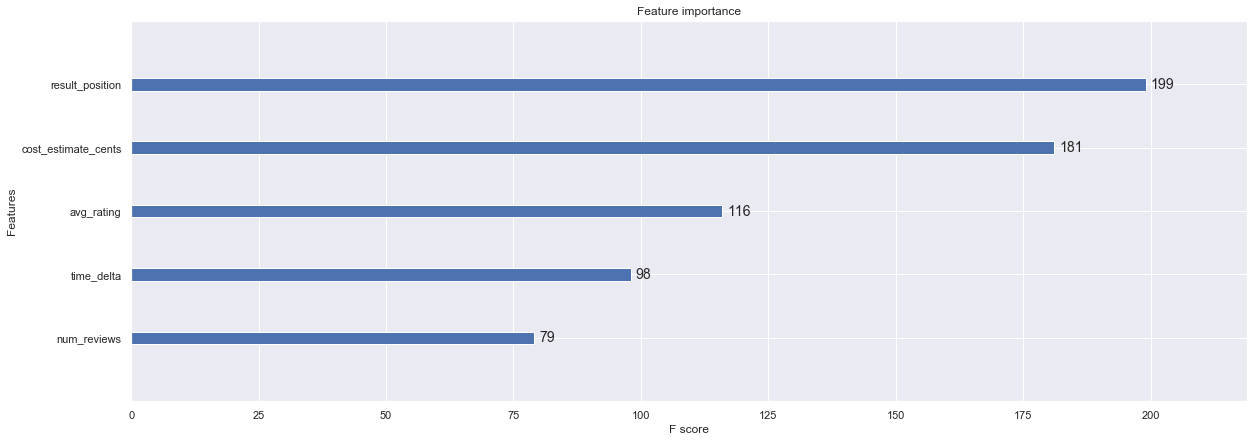

In [77]:
#using XGboost for feature importance
model = XGBClassifier()
model.fit(X, y)

# plot feature importance
plot_importance(model)
pyplot.show()

### Now we will segment by category

## House Cleaning

In [78]:
#Train test split

house_cleaning1 = house_cleaning[['num_reviews','avg_rating','cost_estimate_cents',
                                  'result_position','time_delta','service_page_viewed']]
house_cleaning1 = house_cleaning1.fillna(0)
X = house_cleaning1.loc[:, house_cleaning1.columns != 'service_page_viewed']
y = house_cleaning1.loc[:, house_cleaning1.columns == 'service_page_viewed']

In [79]:
#Address imbalance problem using SMOTE
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no click data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of click data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  24872
Number of no subscription in oversampled data 12436
Number of subscription 12436
Proportion of no click data in oversampled data is  0.5
Proportion of click data in oversampled data is  0.5


/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now our data is balanced. We will move to feature selection and feature importance

It shows that all of the features are beneficial for our model

/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


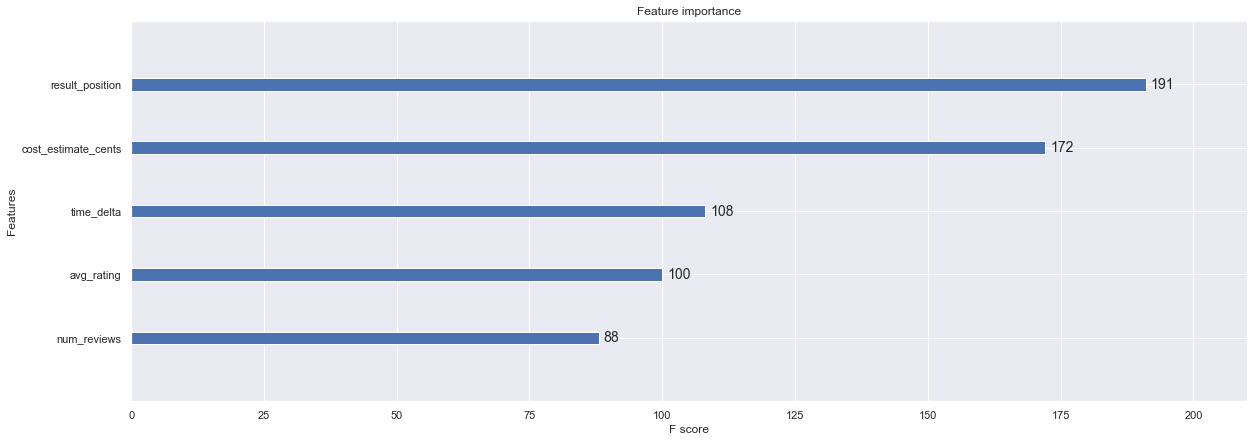

In [80]:
#using XGboost for feature importance
model = XGBClassifier()
model.fit(X, y)

# plot feature importance
plot_importance(model)
pyplot.show()

We can see that result position and cost estimate are the most important factors to the visitors. And they mostly likly to choose the pros with the top position with reasonable price estimate.

## Perform Logistic Regression

In [81]:
#prepare data for feature selection perform
data_final_vars=house_cleaning1.columns.values.tolist()
y=['service_page_viewed']
X=[i for i in data_final_vars if i not in y]

In [82]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True]
[1 1 1 1 1]


/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [83]:
#select features
X=os_data_X[X]
y=os_data_y['y']

In [84]:
#build Logistics model
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.491033
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.292     
Dependent Variable:  y                 AIC:               24435.9360
Date:                2019-10-11 10:44  BIC:               24476.5435
No. Observations:    24872             Log-Likelihood:    -12213.   
Df Model:            4                 LL-Null:           -17240.   
Df Residuals:        24867             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
num_reviews          0.0016   0.0003   6.0357 0.0000  0.0011  0.0021
avg_rating           0.4611 

The model shows that all of the variables are statisitcally significant according to the p-value:

- If the number of reviews increase by 1 unit, the odds of being hired will increase by 0.16% since $e^{0.0016}$ = 1.0016

- If the average rating increase  by 1 unit, the odds of being hired will increase by 58% since $e^{0.4611}$ = 1.58

- If the estimated cost increase by 1 unit, the odds of being hired will remain the same.

- If the result position increase by 1 unit, the odds of being hired will decrease by 44% since $e^{0.6467}$ = 1.44%

- If the time delta increase by 1 unit, the odds of being hired will relatively not making any difference.

In [85]:
#fit the model

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


In [87]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2555 1199]
 [ 598 3110]]


In [88]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.81      0.68      0.74      3754
        True       0.72      0.84      0.78      3708

    accuracy                           0.76      7462
   macro avg       0.77      0.76      0.76      7462
weighted avg       0.77      0.76      0.76      7462



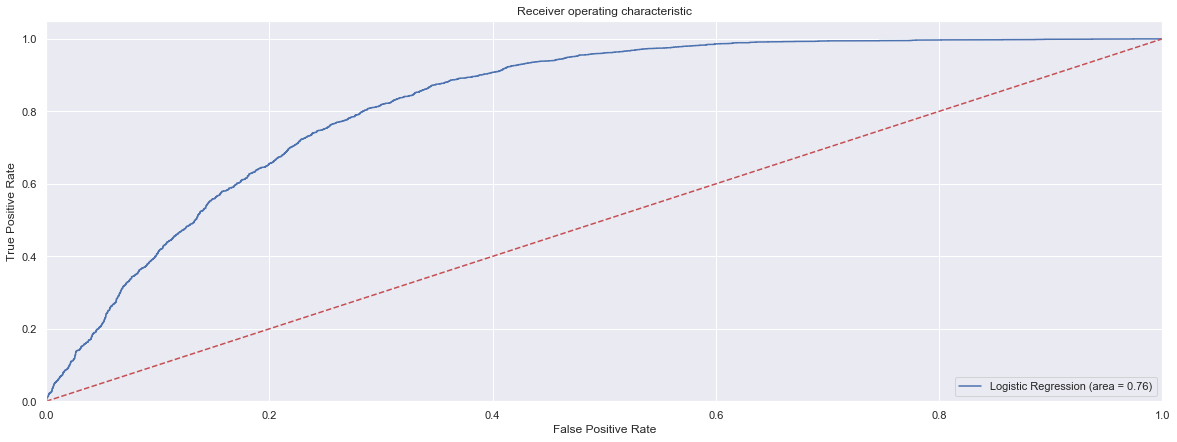

In [89]:
#ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

We have a pretty good model since our percentage of true positive is higher than false positive

## House Moving

In [90]:
#train test split

house_moving1 = house_moving[['num_reviews','avg_rating','cost_estimate_cents',
                                  'result_position','time_delta','service_page_viewed']]
house_moving1 = house_moving1.fillna(0)
X = house_moving1.loc[:, house_moving1.columns != 'service_page_viewed']
y = house_moving1.loc[:, house_moving1.columns == 'service_page_viewed']

In [91]:
#Address imbalance problem using SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no click data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of click data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  8586
Number of no subscription in oversampled data 4293
Number of subscription 4293
Proportion of no click data in oversampled data is  0.5
Proportion of click data in oversampled data is  0.5


/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now our data is balanced. We will move to feature selection and feature importance

It shows that all of the features are beneficial for our model

/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


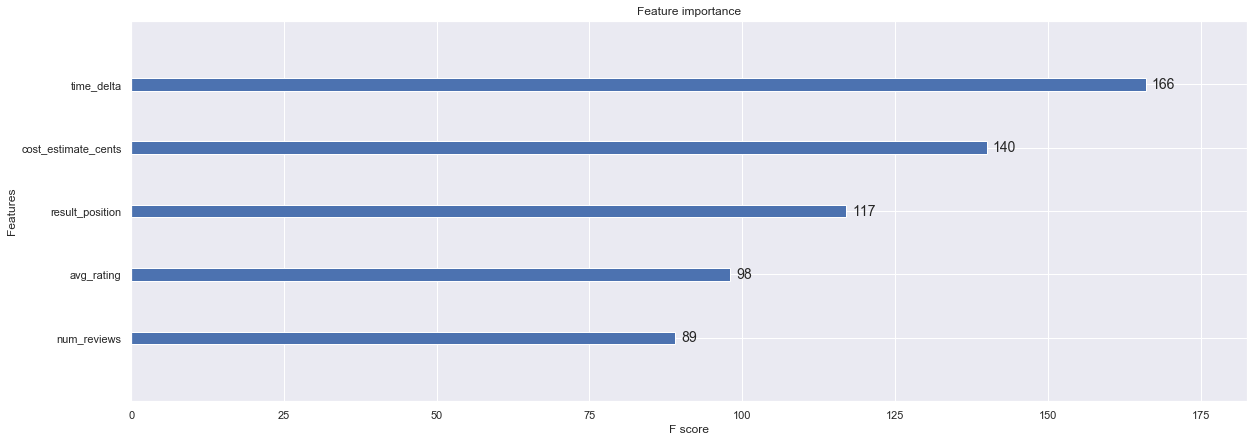

In [92]:
#using XGboost for feature importance

model = XGBClassifier()
model.fit(X, y)

# plot feature importance
plot_importance(model)
pyplot.show()

Similarly, we can see that result position is the most important factor to the visitors. However, in the case of house moving, number of reviews are more important to the visitors than the estimate cost.

In [93]:
#prepare data for feature selection perform

data_final_vars=house_moving1.columns.values.tolist()
y=['service_page_viewed']
X=[i for i in data_final_vars if i not in y]

In [94]:

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True]
[1 1 1 1 1]


/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Build Logistics Regression Model

In [95]:
#select features

X=os_data_X[X]
y=os_data_y['y']

In [96]:
#build Logistics model

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.541277
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.219    
Dependent Variable:   y                 AIC:               9304.8167
Date:                 2019-10-11 10:44  BIC:               9340.1061
No. Observations:     8586              Log-Likelihood:    -4647.4  
Df Model:             4                 LL-Null:           -5951.4  
Df Residuals:         8581              LLR p-value:       0.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       7.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
num_reviews          0.0004   0.0001   3.0457 0.0023  0.0001  0.0007
avg_rating           0.5239 

The model shows that all of the variables are statisitcally significant according to the p-value:

- If the number of reviews increase by 1 unit, the odds of being hired will increase by 0.4% since $e^{0.004}$ = 1.004

- If the average rating increase  by 1 unit, the odds of being hired will increase by 60% since $e^{0.5239}$ = 1.6

- If the estimated cost increase by 1 unit, the odds of being hired will decrease by 0.01% since $e^{0.0001}$ = 1.0001

- If the result position increase by 1 unit, the odds of being hired will decrease by 90% since $e^{0.6467}$ = 1.90

- If the time delta increase by 1 unit, the odds of being hired will relatively not making any difference.

In [97]:
#fit the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/giangnguyen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


In [99]:
#confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 849  433]
 [ 247 1047]]


In [100]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.77      0.66      0.71      1282
        True       0.71      0.81      0.75      1294

    accuracy                           0.74      2576
   macro avg       0.74      0.74      0.73      2576
weighted avg       0.74      0.74      0.73      2576



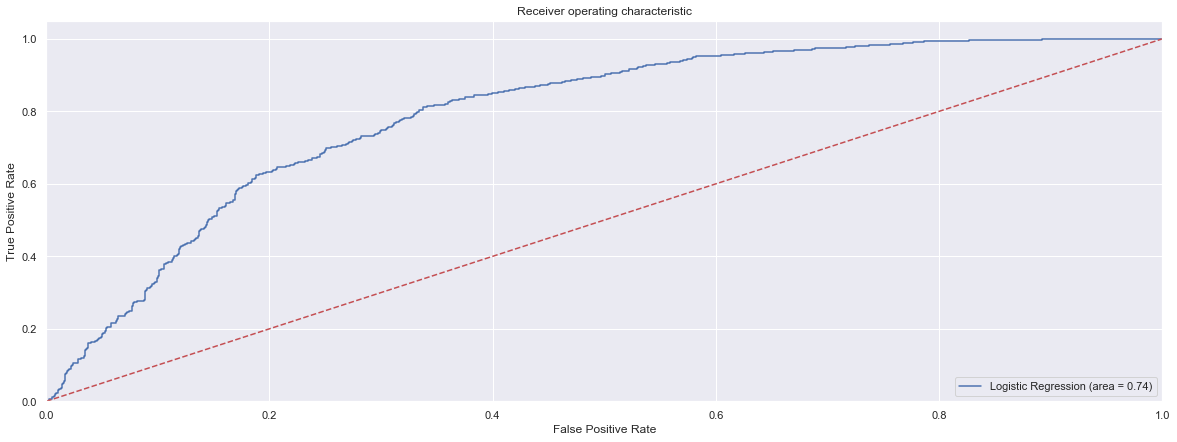

In [101]:
#ROC curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


We have a pretty good model since our percentage of true positive is higher than false positive